# Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.15.1


### Проверка функционала GPU

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13604435128118734783
xla_global_id: -1
]


In [4]:
column_names = ['Cement', 'Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'csMPa']

raw_dataset = pd.read_csv('Data.csv',
                          na_values='?', comment='\t',
                          skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.40


In [6]:
mean_value = dataset['csMPa'].mean()

print("Среднее значение столбца csMPa:", mean_value)
print('Средняя ошибка:', 3.576234/mean_value *100)

Среднее значение столбца csMPa: 35.817961165048544
Средняя ошибка: 9.984471152673308


In [7]:
dataset.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

### Разделение датасета на тренировочную и тестовую части

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,824.0,280.272694,104.483467,102.00,193.125,266.000,350.0000,540.0
slag,824.0,73.171238,85.865727,0.00,0.000,22.000,142.5000,359.4
flyash,824.0,55.318325,64.098118,0.00,0.000,0.000,118.3000,200.1
water,824.0,182.029490,21.287699,121.80,164.900,185.700,192.0000,247.0
superplasticizer,824.0,6.147816,6.000795,0.00,0.000,6.100,10.1250,32.2
coarseaggregate,824.0,973.991019,77.755840,801.00,932.000,968.000,1030.2500,1145.0
fineaggregate,824.0,771.898301,80.031529,594.00,721.750,779.300,824.0000,992.6
age,824.0,45.708738,63.603343,1.00,7.000,28.000,56.0000,365.0
csMPa,824.0,35.739478,16.582095,2.33,23.520,34.425,46.2075,82.6


Отделение целевого значения от объектов

In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('csMPa')
test_labels = test_features.pop('csMPa')

In [11]:
train_labels

747    26.06
718    10.35
175    79.30
828    74.99
713     9.69
       ...  
673    15.03
595    17.60
445    36.56
117    59.80
464    56.81
Name: csMPa, Length: 824, dtype: float64

Нормализация данных

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cement,280.272694,104.483467
slag,73.171238,85.865727
flyash,55.318325,64.098118
water,182.029490,21.287699
superplasticizer,6.147816,6.000795
coarseaggregate,973.991019,77.755840
fineaggregate,771.898301,80.031529
age,45.708738,63.603343
csMPa,35.739478,16.582095


In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [14]:
normalizer.adapt(np.array(train_features))

In [15]:
print(normalizer.mean.numpy())

[[280.273  73.171  55.318 182.029   6.148 973.991 771.898  45.709]]


In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 500.    0.    0.  200.    0. 1125.  613.    3.]]

Normalized: [[ 2.1  -0.85 -0.86  0.84 -1.03  1.94 -1.99 -0.67]]


In [17]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [18]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 140ms/step


array([[ 3.059],
       [-2.231],
       [-0.455],
       [ 2.547],
       [-2.331],
       [ 0.36 ],
       [ 0.62 ],
       [ 0.643],
       [ 3.367],
       [ 1.169]], dtype=float32)

In [19]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [20]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: total: 1.67 s
Wall time: 7.05 s


In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [csMPa]')
  plt.legend()
  plt.grid(True)

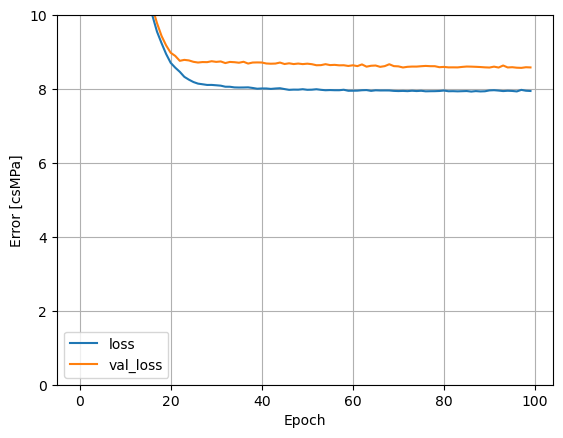

In [22]:
plot_loss(history)

In [23]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Регрессия с помощью глубокой нейронной сети (DNN)

In [29]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [32]:
import tensorflow as tf
if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


In [30]:
train_data = []
def build_and_compile_model(norm, layer1, layer2):
  model = keras.Sequential([
      norm,
      layers.Dense(layer1, activation='relu'),
      layers.Dense(layer2, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))
  return model
# def train(dnn_model, epochs):
#     %%time
#     history = dnn_model.fit(
#         train_features,
#         train_labels,
#         validation_split=0.2,
#         verbose=0, epochs=epochs)
#     return history
import time

for layer1 in range(16, 144, 16):
    for layer2 in range(16, 144, 16):
        for epochs in range(100, 1100, 100):
            dnn_model = build_and_compile_model(normalizer, layer1, layer2)
            # dnn_model.summary()
            
            start_time = time.time()
            history = dnn_model.fit(
                train_features,
                train_labels,
                validation_split=0.2,
                verbose=0, 
                epochs=epochs)
            end_time = time.time()
            print(f"Training time for model l1-{layer1}\tl2-{layer2}\te{epochs}: {end_time - start_time} seconds")
            train_data.append([layer1, layer2, epochs, end_time - start_time, dnn_model.evaluate(test_features, test_labels, verbose=0)])
            test_results[f'dnn_model l1-{layer1}| l2-{layer2}| epochs-{epochs}'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Training time for model l1-16	l2-16	e100: 9.08047866821289 seconds
Training time for model l1-16	l2-16	e200: 16.25394082069397 seconds
Training time for model l1-16	l2-16	e300: 22.590927124023438 seconds


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [csMPa]']).T

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [csMPa]']).T

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [csMPa]')
plt.ylabel('Predictions [csMPa]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [csMPa]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model.save('dnn_model.keras')

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [csMPa]']).T

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

def build_and_compile_model(norm, layer1, layer2):
    model = keras.Sequential([
        norm,
        layers.Dense(layer1, activation='relu'),
        layers.Dense(layer2, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.0005))
    return model

# Пример слоя нормализации
input_shape = [8]  # Замените на фактическую форму входных данных
norm = layers.Normalization(input_shape=input_shape)

# Создание модели
model = build_and_compile_model(norm, 64, 32)

# Явно построить модель
model.build(input_shape=(None, 10))

# Вывод архитектуры модели в текстовом формате
model.summary()

# Визуализация модели
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
